In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
from arcgis.gis import GIS
import pykrige.uk
from tqdm.notebook import tqdm
import datetime
from sklearn.linear_model import LinearRegression
import matplotlib
from scipy.spatial import cKDTree
from pygeostat.data import iotools
import scipy

In [6]:
def ckdnearest(gdA, gdB):
    '''scipy's binary tree search for finding nearest neighbor points between two geodataframes'''
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

In [186]:
from scipy.spatial import cKDTree

class tree(object):
    """
    Compute the score of query points based on the scores of their k-nearest neighbours,
    weighted by the inverse of their distances.
    @reference:
    https://en.wikipedia.org/wiki/Inverse_distance_weighting
    Arguments:
    ----------
        X: (N, d) ndarray
            Coordinates of N sample points in a d-dimensional space.
        z: (N,) ndarray
            Corresponding scores.
        leafsize: int (default 10)
            Leafsize of KD-tree data structure;
            should be less than 20.
    Returns:
    --------
        tree instance: object
    Example:
    --------
    # 'train'
    idw_tree = tree(X1, z1)
    # 'test'
    spacing = np.linspace(-5., 5., 100)
    X2 = np.meshgrid(spacing, spacing)
    X2 = np.reshape(X2, (2, -1)).T
    z2 = idw_tree(X2)
    See also:
    ---------
    demo()
    """
    def __init__(self, X=None, z=None, leafsize=10):
        if not X is None:
            self.tree = cKDTree(X, leafsize=leafsize )
        if not z is None:
            self.z = np.array(z)

    def fit(self, X=None, z=None, leafsize=10):
        """
        Instantiate KDtree for fast query of k-nearest neighbour distances.
        Arguments:
        ----------
            X: (N, d) ndarray
                Coordinates of N sample points in a d-dimensional space.
            z: (N,) ndarray
                Corresponding scores.
            leafsize: int (default 10)
                Leafsize of KD-tree data structure;
                should be less than 20.
        Returns:
        --------
            idw_tree instance: object
        Notes:
        -------
        Wrapper around __init__().
        """
        return self.__init__(X, z, leafsize)

    def __call__(self, X, k=6, eps=1e-6, p=2, regularize_by=1e-9):
        """
        Compute the score of query points based on the scores of their k-nearest neighbours,
        weighted by the inverse of their distances.
        Arguments:
        ----------
            X: (N, d) ndarray
                Coordinates of N query points in a d-dimensional space.
            k: int (default 6)
                Number of nearest neighbours to use.
            p: int or inf
                Which Minkowski p-norm to use.
                1 is the sum-of-absolute-values "Manhattan" distance
                2 is the usual Euclidean distance
                infinity is the maximum-coordinate-difference distance
            eps: float (default 1e-6)
                Return approximate nearest neighbors; the k-th returned value
                is guaranteed to be no further than (1+eps) times the
                distance to the real k-th nearest neighbor.
            regularise_by: float (default 1e-9)
                Regularise distances to prevent division by zero
                for sample points with the same location as query points.
        Returns:
        --------
            z: (N,) ndarray
                Corresponding scores.
        """
        self.distances, self.idx = self.tree.query(X, k, eps=eps, p=p)
        self.distances += regularize_by
        weights = self.z[self.idx.ravel()].reshape(self.idx.shape)
        mw = np.sum(weights/self.distances, axis=1) / np.sum(1./self.distances, axis=1)
        return mw

    def transform(self, X, k=6, p=2, eps=1e-6, regularize_by=1e-9):
        """
        Compute the score of query points based on the scores of their k-nearest neighbours,
        weighted by the inverse of their distances.
        Arguments:
        ----------
            X: (N, d) ndarray
                Coordinates of N query points in a d-dimensional space.
            k: int (default 6)
                Number of nearest neighbours to use.
            p: int or inf
                Which Minkowski p-norm to use.
                1 is the sum-of-absolute-values "Manhattan" distance
                2 is the usual Euclidean distance
                infinity is the maximum-coordinate-difference distance
            eps: float (default 1e-6)
                Return approximate nearest neighbors; the k-th returned value
                is guaranteed to be no further than (1+eps) times the
                distance to the real k-th nearest neighbor.
            regularise_by: float (default 1e-9)
                Regularise distances to prevent division by zero
                for sample points with the same location as query points.
        Returns:
        --------
            z: (N,) ndarray
                Corresponding scores.
        Notes:
        ------
        Wrapper around __call__().
        """
        return self.__call__(X, k, eps, p, regularize_by)

## Load Data

In [7]:
#well_measurements = pd.read_csv('./well_data/brewster_data.csv')
#well_measurements.info()

In [99]:
#well_measurements = pd.read_csv('./shallow_measurements_cvhm.csv', parse_dates=['MSMT_DATE'])
well_measurements = pd.read_csv('./shallow_measurements_all_cvhm.csv', parse_dates=['MSMT_DATE'])
site_points = [Point(xy) for xy in zip(well_measurements["LONGITUDE"], well_measurements["LATITUDE"])]
crs_latlon='epsg:4326' # WGS 84
crs_projected='epsg:3488' # California Albers
#crs_num = 3488
well_measurements = gpd.GeoDataFrame(well_measurements, crs=crs_latlon, geometry=site_points)
well_measurements = well_measurements.to_crs(crs_projected)
#well_measurements = well_measurements.set_index(['MSMT_DATE'])
#well_measurements = well_measurements.sort_index(ascending=True)

/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Filter Data by Date

In [100]:
target_year = '2021'

target_season = 'spring'

if target_season == 'spring':
    start_month = '01'
    end_month = '06'
else:
    start_month = '06'
    end_month='12'

mask = ((well_measurements['MSMT_DATE'] > target_year+start_month+'01') & 
        (well_measurements['MSMT_DATE'] <= target_year+end_month+'01'))

In [101]:
timeframed_measurements = well_measurements.loc[mask]
#timeframed_measurements = well_measurements
timeframed_measurements = timeframed_measurements[timeframed_measurements['GSE_GWE'].notnull()]

In [102]:
print(timeframed_measurements.shape)

(2067, 51)


Taking only those points whose water surface elevation is lower than ground surface elevation.

In [103]:
#timeframed_measurements = timeframed_measurements[timeframed_measurements['GSE_WSE'] > 0]
timeframed_measurements = timeframed_measurements[timeframed_measurements['GSE_GWE'] > 0]
print(timeframed_measurements.columns)

Index(['Unnamed: 0', 'SITE_CODE', 'WLM_ID', 'MSMT_DATE', 'WLM_RPE', 'WLM_GSE',
       'GWE', 'GSE_GWE', 'WLM_QA_DESC', 'WLM_DESC', 'WLM_ACC_DESC',
       'WLM_ORG_NAME', 'COOP_ORG_NAME', 'MONITORING_PROGRAM', 'MSMT_CMT',
       'STN_ID', 'SWN', 'WELL_NAME', 'LATITUDE', 'LONGITUDE', 'GSE',
       'GSE_METHOD', 'GSE_ACC', 'BASIN_CODE', 'BASIN_NAME', 'COUNTY_NAME',
       'WELL_DEPTH', 'WELL_USE', 'WELL_TYPE', 'WCR_NO', 'TOP_PRF_INT_0',
       'BOT_PRF_INT_0', 'TOP_PRF_INT_1', 'BOT_PRF_INT_1', 'TOP_PRF_INT_2',
       'BOT_PRF_INT_2', 'TOP_PRF_INT_3', 'BOT_PRF_INT_3', 'TOP_PRF_INT_4',
       'BOT_PRF_INT_4', 'TOP_PRF_INT_5', 'BOT_PRF_INT_5', 'TOP_PRF_INT_6',
       'BOT_PRF_INT_6', 'TOP_PRF_INT_7', 'BOT_PRF_INT_7', 'TOP_PRF_INT_8',
       'BOT_PRF_INT_8', 'TOP_PRF_INT_9', 'BOT_PRF_INT_9', 'geometry'],
      dtype='object')


## Site filtering

In [88]:
timeframed_measurements['DROP'] = True

In [89]:
site_codes = list(timeframed_measurements['SITE_CODE'].unique())
print(len(site_codes))
for site_code in site_codes:
    site_code_timeframed_measurements = timeframed_measurements[timeframed_measurements['SITE_CODE']==site_code]
    if len(site_code_timeframed_measurements) == 1:
        timeframed_measurements[timeframed_measurements['SITE_CODE']==site_code]['DROP'] = False
    else:
        site_code_timeframed_measurements["CLOSEST"] = abs(site_code_timeframed_measurements["MSMT_DATE"] - 
                                            datetime.datetime(2021, 3, 15))
        index_min = site_code_timeframed_measurements["CLOSEST"].idxmin()
        timeframed_measurements[timeframed_measurements['SITE_CODE']==site_code].loc[index_min, "DROP"] = False


686


/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying t

/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying t

/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying t

/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying t

/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying t

/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to 

/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value i

/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is 

/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying t

/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying t

/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying t

In [90]:
timeframed_measurements.drop(timeframed_measurements.index[timeframed_measurements['DROP']==True], inplace=True)

## Extract X Y and Depth measurements + LVM (Locally Varying Mean) Trend Removal

In [342]:
#timeframed_measurements_x = timeframed_measurements['geometry'].x
#timeframed_measurements_y = timeframed_measurements['geometry'].y
timeframed_measurements_x = timeframed_measurements["LONGITUDE"]
timeframed_measurements_y = timeframed_measurements["LATITUDE"]
timeframed_measurements_z = timeframed_measurements['GSE_GWE']
timeframed_measurements_type = timeframed_measurements["WELL_USE"]
print(np.unique(timeframed_measurements_type))

['Industrial' 'Irrigation' 'Observation' 'Other' 'Public Supply'
 'Residential' 'Stockwatering' 'Unknown']


In [343]:
print(len(timeframed_measurements_x))
print(len(timeframed_measurements_type))

2060
2060


In [344]:
x_ = np.arange(-123, -118, 0.05)
y_ = np.arange(34.5, 41, 0.05)

xx,yy = np.meshgrid(x_,y_,indexing = 'ij')
print(xx.shape)
xx_flat = xx.reshape(-1)
yy_flat = yy.reshape(-1)

meshgrid_points = [Point(xy) for xy in zip(xx_flat, 
                                           yy_flat)]
meshgrid_frame = gpd.GeoDataFrame(meshgrid_points, crs=crs_latlon, geometry=meshgrid_points)

(100, 130)


In [345]:
#meshgrid_frame = meshgrid_frame.to_crs(crs_projected)

In [346]:
xx_flat = meshgrid_frame['geometry'].x
yy_flat = meshgrid_frame['geometry'].y

In [347]:
print(max(xx_flat))
print(max(yy_flat))
print(min(xx_flat))
print(min(yy_flat))

-118.05000000000028
40.94999999999963
-123.0
34.5


In [348]:
#well_measurements_LVM.to_csv('shallow_measurements_timeframed_measurements_lvm_cvhm.csv')

In [349]:
#shallow_measurements_csv = iotools.read_csv('shallow_measurements_timeframed_measurements_lvm_cvhm.csv', headeronly=False, tmin=None)

In [350]:
#iotools.write_gslib(shallow_measurements_csv, 'shallow_measurements_all_cvhm_no_trend_gslib', variables=['LONGITUDE', 'LATITUDE', 'GSE_GWE_NO_TREND'])

Stacking the x, y, and z data together in a new array

In [351]:
timeframed_measurements_xyz = np.vstack((timeframed_measurements_x, timeframed_measurements_y, timeframed_measurements_z)).T
print(len(timeframed_measurements_xyz))

2060


## Bootstrap and Kriging

In [352]:
rows_to_delete = []
for row_index in range(len(timeframed_measurements_xyz)-1):
    if (timeframed_measurements_xyz[row_index,0] == timeframed_measurements_xyz[row_index+1,0] and
        timeframed_measurements_xyz[row_index,1] == timeframed_measurements_xyz[row_index+1,1]):
        rows_to_delete.append(row_index)
print(len(rows_to_delete))


1421


In [358]:
print(timeframed_measurements_xyz.shape)
print(timeframed_measurements_type.shape)
print(len(rows_to_delete))
timeframed_measurements_xyz = np.delete(timeframed_measurements_xyz, rows_to_delete, axis=0)
#timeframed_measurements_type = np.delete(np.array(timeframed_measurements_type), rows_to_delete)

(2060, 3)
(639,)
1421


IndexError: index 639 is out of bounds for axis 0 with size 639

In [359]:
idw_tree = tree(timeframed_measurements_xyz[:,:2], timeframed_measurements_xyz[:,2])

In [360]:
xx_yy = np.array((xx_flat,yy_flat)).T
#z = RBF(xx_yy)
z = idw_tree(xx_yy)
print(z.shape)
print(z.shape)
z = z.reshape(100, 130)

(13000,)
(13000,)


In [361]:
print(len(timeframed_measurements_xyz[:,2]))

639


In [362]:
bootstrap_timeframed_measurements_xyz = np.zeros((100, int(len(timeframed_measurements_xyz)*0.8), 3))
p_array = np.ones((int(len(timeframed_measurements_xyz))))*0.2/len(
    timeframed_measurements_type[timeframed_measurements_type!='Observation'])
print(len(timeframed_measurements_xyz))
print(len(timeframed_measurements_type))
p_array[timeframed_measurements_type=='Observation']=0.8/len(
timeframed_measurements_type[timeframed_measurements_type=='Observation'])
for i in range(len(bootstrap_timeframed_measurements_xyz)):
    bootstrap_indices = np.random.choice(np.arange(len(timeframed_measurements_xyz)), 
                                         size=int(len(timeframed_measurements_xyz)*0.8),
                                        replace=False,
                                        p=p_array)
    bootstrap_timeframed_measurements_xyz[i] = timeframed_measurements_xyz[bootstrap_indices]
#for i in range(len(bootstrap_timeframed_measurements_xyz)):
#    boostrap_indices = np.random.choice(timeframed_measurements_xyz

639
639


In [363]:
print(len(timeframed_measurements_xyz))
print(bootstrap_timeframed_measurements_xyz[0])

639
[[-121.57     38.1343    5.99  ]
 [-121.672    39.0086    9.46  ]
 [-122.236    39.6332  116.52  ]
 ...
 [-121.767    38.9803    4.8   ]
 [-121.646    39.1068   26.1   ]
 [-120.263    36.6098   75.    ]]


Use grid from above

Set up bootstrap 

In [364]:
bootstrap_IDW = []
for i in tqdm(range(len(bootstrap_timeframed_measurements_xyz))):
    bootstrap_IDW.append(tree(bootstrap_timeframed_measurements_xyz[i,:,:2],
                            bootstrap_timeframed_measurements_xyz[i,:,2]))

  0%|          | 0/100 [00:00<?, ?it/s]

In [365]:
bootstrap_realizations = []
for i in tqdm(range(len(bootstrap_IDW))):
    z = bootstrap_IDW[i](xx_yy)
    bootstrap_realizations.append(z)


  0%|          | 0/100 [00:00<?, ?it/s]

In [366]:
print(bootstrap_realizations[0].shape)

(13000,)


## Plot Results

In [367]:
CA_map = gpd.read_file('Shapefiles/CA_State_TIGER2016.shp')
#CA_map.crs = 'epsg:4269'
#CA_map.to_crs(epsg='4326', inplace=True)
print(CA_map.crs)
CA_map.to_crs(epsg='4326', inplace=True)

CV_map = gpd.read_file('Shapefiles/Alluvial_Bnd.shp')
#CA_map.crs = 'epsg:4269'
#CA_map.to_crs(epsg='4326', inplace=True)
print(CV_map.crs)
CV_map.to_crs(epsg='4326', inplace=True)

PROJCS["WGS_1984_Web_Mercator_Auxiliary_Sphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"]]
PROJCS["NAD_1983_Albers",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-120],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PAR

In [368]:
new_binary = mpl.colors.ListedColormap(np.array([[1., 1., 1., 1.],
       [0., 0., 0., 0.]]))
CV_overlay = np.zeros(xx.shape)
CV_geom = CV_map['geometry'].values[0]
for i in tqdm(range(len(CV_overlay))):
    for j in range(len(CV_overlay[0,:])):
        potentialPoint = Point(xx[i,j], yy[i,j])
        if potentialPoint.within(CV_geom):
            CV_overlay[i,j] = 1

  0%|          | 0/100 [00:00<?, ?it/s]

In [369]:
z_mean = np.array(bootstrap_realizations)
z_mean = np.reshape(z_mean, (100,100,130))
z_mean = np.mean(z_mean, axis=0)
print(z_mean.shape)
#z_mean = np.reshape(z_mean, (100,130))
print(z_mean.shape)

(100, 130)
(100, 130)


In [370]:
z_var = np.array(bootstrap_realizations)
z_var = np.sqrt(np.var(z_var, axis=0))
print(z_var.shape)
z_var = np.reshape(z_var, (100,130))

(13000,)


Text(306.5740441012261, 0.5, 'Latitude')

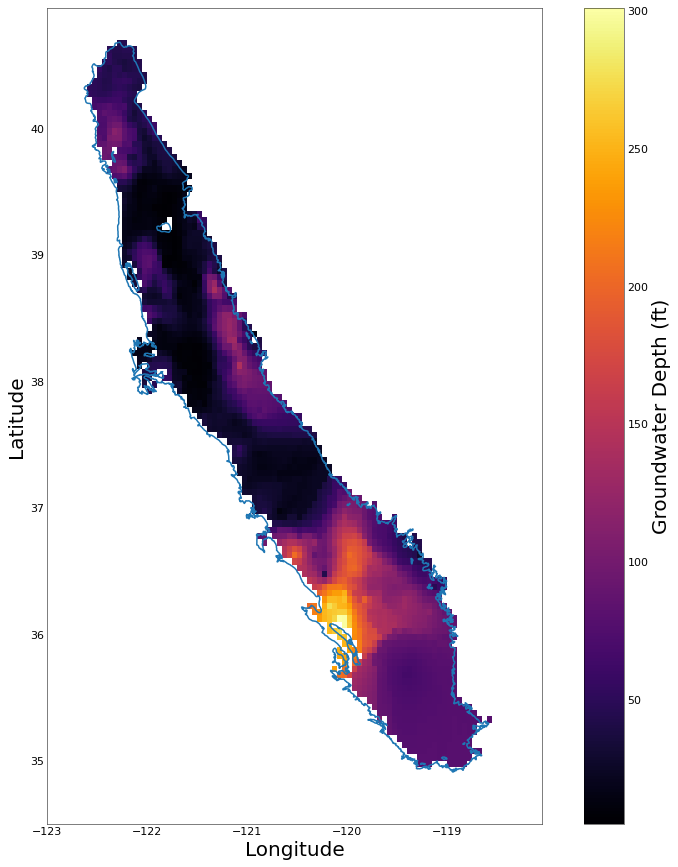

In [371]:
fig, ax = plt.subplots(figsize=(15,15))
#CA_map.boundary.plot(ax=ax, zorder=3)
CV_map.boundary.plot(ax=ax, zorder=4)
plt.pcolormesh(xx, yy, z_mean, zorder=1, cmap='inferno')
#plt.colorbar()
plt.colorbar().set_label(label='Groundwater Depth (ft)',size=20)
#plt.scatter(timeframed_measurements_xyz[:,0], timeframed_measurements_xyz[:,1], color='red')
plt.pcolormesh(xx, yy, CV_overlay, cmap=new_binary, zorder=2)
#plt.title('IDW interpolation over entire central valley: Spring 2020 (mean of 100 realizations)', fontsize=20)
plt.xlabel('Longitude', fontsize=20)
plt.ylabel('Latitude', fontsize=20)
#plt.savefig('OK_CV_only_bootstrap.png', dpi=300)

Text(306.5740441012261, 0.5, 'Latitude')

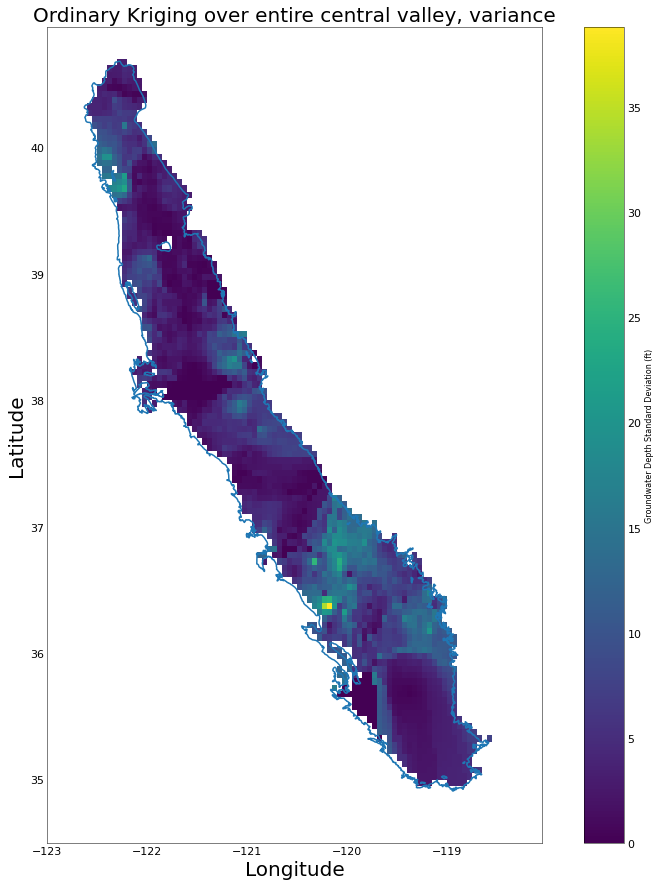

In [372]:
fig, ax = plt.subplots(figsize=(15,15))
#CA_map.boundary.plot(ax=ax, zorder=3)
CV_map.boundary.plot(ax=ax, zorder=4)
plt.pcolormesh(xx, yy, z_var, zorder=1)
plt.colorbar(label='Groundwater Depth Standard Deviation (ft)')
plt.pcolormesh(xx, yy, CV_overlay, cmap=new_binary, zorder=2)
plt.title('Ordinary Kriging over entire central valley, variance', fontsize=20)
plt.xlabel('Longitude', fontsize=20)
plt.ylabel('Latitude', fontsize=20)
#plt.savefig('OK_CV_only_vari.png', dpi=300)

piezometer at every well?

consider agricultural and residential wells in areas with not many observation wells

check quality control codes

worried about semiconfined (could be higher than the water table if pressurized) Need some method of confirming if a well is in an unconfined vs semiconfined zone (clay percent? well logs? insar?)

Christina thinks the answer could be in the well logs (line for depth of first water -> water level at level of confirmation)

DWR has some of those logs maybe? still a rangling effort